In [4]:
import pandas as pd
import numpy as np
import s3fs
import matplotlib.pyplot as plt
import seaborn as sns
import io

In [5]:
# --- 1. SET SEED FOR REPRODUCIBILITY ---
# This ensures you get the exact same results every time you run this cell.
np.random.seed(42)

MINIO_OPTS = {
    "key": "admin",
    "secret": "password123",
    "client_kwargs": {"endpoint_url": "http://localhost:9000"}
}

print("Phase 5: Starting Monte Carlo Simulation...")
    
# 1. Load Merged Data from Gold
try:
    df = pd.read_parquet("s3://gold/merged_data/merged_data.parquet", storage_options=MINIO_OPTS)
    print(f"Loaded {len(df)} records from Gold Layer.")
except Exception as e:
    print(f"Error loading data: {e}")

Phase 5: Starting Monte Carlo Simulation...
Loaded 5250 records from Gold Layer.


In [6]:
df.head()

,traffic_id,date_time,city,area,vehicle_count,road_condition,avg_speed_kmh,congestion_level,accident_count,visibility_traffic,weather_id,season,temperature_c,humidity,rain_mm,weather_condition,wind_speed_kmh,visibility_weather,air_pressure_hpa
0,9001,2024-01-01 00:00:00,London,Camden,390.0,Snowy,78.737236,Low,0.0,10000.0,5001,Winter,-2.21,0.604692,15.693069,Snow,43.600000,3924.875,1010.73
1,9002,2024-01-01 02:00:00,London,Camden,49.0,Dry,124.040482,Low,2.5,10000.0,5002,Winter,14.46,80.000000,4.201908,Clear,78.820000,9857.000,1004.81
2,9003,2024-01-01 04:00:00,London,Chelsea,432.0,Snowy,48.830000,Low,2.5,10000.0,5003,Winter,4.25,84.000000,0.000000,Snow,21.420000,9620.000,996.09
3,9004,2024-01-01 06:00:00,London,Islington,884.0,Dry,83.270000,Low,0.0,10000.0,5004,Winter,1.41,74.000000,0.000000,Clear,54.420000,11148.000,1007.39
4,9005,2024-01-01 08:00:00,London,Greenwich,3382.0,Dry,89.618408,Low,0.0,10000.0,5005,Winter,7.51,52.000000,0.000000,Clear,66.936188,11599.000,999.58


Simulating scenario: Baseline (All Data)...
Simulating scenario: Heavy Rain (>20mm)...
Simulating scenario: Extreme Cold (<0°C)...
Simulating scenario: High Humidity (>80%)...
Simulating scenario: Low Visibility (<4000m)...
Simulating scenario: Stormy Weather...

FINAL SIMULATION SUMMARY TABLE
               Scenario  Avg_Congestion_Prob  Avg_Accidents_Expected_Per_Batch  95%_Confidence_Interval_Congestion  95%_Worst_Case_Accidents
    Baseline (All Data)             0.228680                           58.9297                                0.30                      76.0
     Heavy Rain (>20mm)             0.256624                           70.5099                                0.33                      87.5
    Extreme Cold (<0°C)             0.236308                           63.3438                                0.31                      79.5
   High Humidity (>80%)             0.249852                           62.9156                                0.32                      80.0


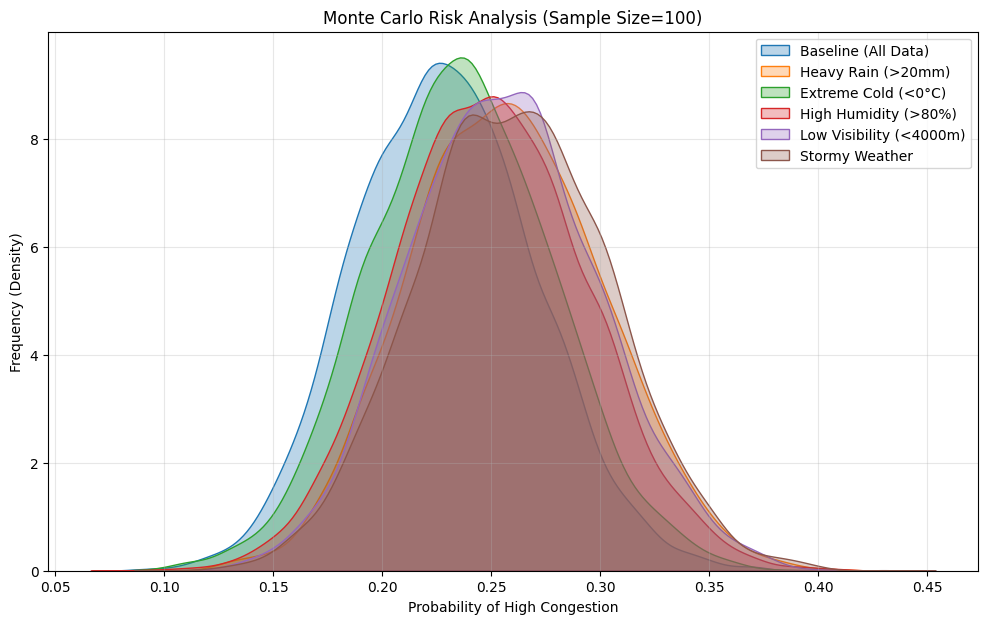

In [7]:
# 2. Define Simulation Scenarios
# We create masks (filters) for each weather condition
scenarios = {
    "Baseline (All Data)": pd.Series([True] * len(df)),
    "Heavy Rain (>20mm)": df['rain_mm'] > 20,
    "Extreme Cold (<0°C)": df['temperature_c'] < 0,
    "High Humidity (>80%)": df['humidity'] > 80,
    "Low Visibility (<4000m)": df['visibility_weather'] <= 4000,
    "Stormy Weather": df['weather_condition'] == 'Storm'
}

# Storage for the Full CSV (30,000+ rows)
raw_simulation_data = []
    
# Storage for the Summary Table (6 rows)
summary_stats = []
    
# Storage for Plotting
plot_data = {}
    
# Parameters
N_SIMULATIONS = 5000
SAMPLE_SIZE = 100

for name, mask in scenarios.items():
    subset = df[mask]
        
    if len(subset) < 10:
        print(f"Skipping '{name}': Not enough data ({len(subset)} rows)")
        continue

    print(f"Simulating scenario: {name}...")

    # Temporary lists for this loop
    batch_congestion_probs = []
    batch_accident_counts = []

    # MONTE CARLO LOOP
    for i in range(N_SIMULATIONS):
        # 1. Bootstrap Resample
        sample = subset.sample(n=SAMPLE_SIZE, replace=True)
            
        # 2. Calculate Congestion Probability (Risk)
        jam_count = len(sample[sample['congestion_level'] == 'High'])
        prob_jam = jam_count / SAMPLE_SIZE
            
        # 3. Calculate Accident Count
        total_accidents = sample['accident_count'].sum()

        # Store Raw Data for CSV
        raw_simulation_data.append({
            "Scenario": name,
            "Run_ID": i + 1,
            "Congestion_Probability": prob_jam,
            "Total_Accidents": total_accidents
        })
            
        # Store for Stats
        batch_congestion_probs.append(prob_jam)
        batch_accident_counts.append(total_accidents)

    # Calculate Summary Stats for the Table
    summary_stats.append({
        "Scenario": name,
        "Avg_Congestion_Prob": np.mean(batch_congestion_probs),
        "Avg_Accidents_Expected_Per_Batch": np.mean(batch_accident_counts),
        "95%_Confidence_Interval_Congestion": np.percentile(batch_congestion_probs, 95),
        "95%_Worst_Case_Accidents": np.percentile(batch_accident_counts, 95)
    })
        
    plot_data[name] = batch_congestion_probs

# --- OUTPUT 1: The Summary Table (Printed + Uploaded) ---
summary_df = pd.DataFrame(summary_stats)

# A. Print to Console
print("\n" + "="*50)
print("FINAL SIMULATION SUMMARY TABLE")
print("="*50)
print(summary_df.to_string(index=False))
print("="*50 + "\n")

# Initialize S3 FileSystem
fs = s3fs.S3FileSystem(**MINIO_OPTS)

# B. Upload Summary CSV to Gold (NEW STEP)
summary_buffer = io.BytesIO()
summary_df.to_csv(summary_buffer, index=False)
with fs.open("gold/monte_carlo/simulation_summary.csv", "wb") as f:
    f.write(summary_buffer.getvalue())
print("-> Saved 'simulation_summary.csv' to Gold.")


# --- OUTPUT 2: The Full Raw Dataset (Saved to CSV) ---
full_sim_df = pd.DataFrame(raw_simulation_data)
    
csv_buffer = io.BytesIO()
full_sim_df.to_csv(csv_buffer, index=False)
    
with fs.open("gold/monte_carlo/simulation_results.csv", "wb") as f:
    f.write(csv_buffer.getvalue())
print(f"-> Saved 'simulation_results.csv' ({len(full_sim_df)} rows) to Gold.")


# --- OUTPUT 3: The Distribution Plot (Saved to PNG) ---
plt.figure(figsize=(12, 7))
for name, data in plot_data.items():
    sns.kdeplot(data, label=name, fill=True, alpha=0.3)
    
plt.title(f"Monte Carlo Risk Analysis (Sample Size={SAMPLE_SIZE})")
plt.xlabel("Probability of High Congestion")
plt.ylabel("Frequency (Density)")
plt.legend()
plt.grid(True, alpha=0.3)
    
img_buffer = io.BytesIO()
plt.savefig(img_buffer, format='png')
img_buffer.seek(0)
    
with fs.open("gold/monte_carlo/congestion_dist_plot.png", "wb") as f:
    f.write(img_buffer.getvalue())
print("-> Saved 'congestion_dist_plot.png' to Gold.")